In [19]:
import numpy as np
import scipy.interpolate as si
import matplotlib.pyplot as plt
from scipy.integrate import quad
import skfda
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from models import *
from data_generation import *
from utils import *

In [20]:
def generate_data(J, d, sigma, theta):
    """
    Generate time-series data based on B-spline basis and FPCA.
    d: number of curves
    J: number of basis
    sigma: a J*J matrix representing the sigma operator
    theta: variance of Z_t
    beta: coefficient for generating Y_t
    """
    np.random.seed(42)
    Z_coef = np.random.randn(d, J)
    X_coef = np.zeros((d, J))
    for t in range(d):
        if t == 0:
            X_coef[t] = Z_coef[t]
        else:
            X_coef[t] = Z_coef[t] + X_coef[t - 1] @ theta
    '''
    # Compute Y_t
    Y = np.zeros(d)
    for t in range(J - 1, d):
        Y[t] = sum(np.trapz(beta[j] * X[t - j], s_values) for j in range(J - 1))
    
    '''
    return X_coef



In [21]:
J = 8
d = 50
sigma1 = np.repeat(1,J)
theta1 = np.diag(np.repeat(0.8,J))


In [22]:
X_coef = generate_data(J = J, d = d, sigma = sigma1, theta = theta1)

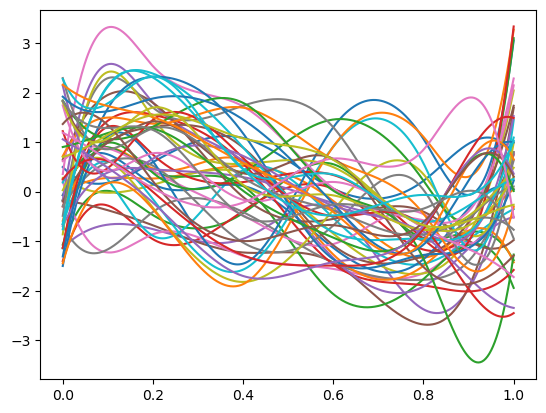

In [23]:
Bbasis = BSplineBasis(domain_range=(0, 1), n_basis=J)
fd_basis = skfda.FDataBasis(
    basis=Bbasis,
    coefficients= X_coef
)
fd_basis.plot()
plt.show()


In [24]:
fpca = FPCA(n_components=6)
fpca.fit(fd_basis)
scores = fpca.transform(fd_basis)
# Explained variance ratio
print("Explained variance by each PC:", fpca.explained_variance_ratio_)
sum(fpca.explained_variance_ratio_)

Explained variance by each PC: [0.41899084 0.27390619 0.13700896 0.07508644 0.04266228 0.02708152]


0.9747362266019141

In [25]:
scores.shape

(50, 6)

In [26]:
# Compute the integral of each basis function over [0,1]
def basis_integral(j):
    """Compute the integral of the j-th basis function over [0,1]."""
    return quad(lambda s: Bbasis(s)[j], 0, 1)[0]

I_j = np.array([basis_integral(j) for j in range(J)])

# Define beta coefficients (random or fixed values)
beta = np.random.randn(J)

# Compute Y
noise = np.random.normal(0, 1, size=d)
Y_np = np.sin(np.sum(X_coef * beta * I_j, axis=1)) + noise

In [27]:
Y_np.shape

(50,)

In [28]:
scores.shape

(50, 6)

In [29]:
X = torch.tensor(scores.T, dtype=torch.float32) 
print(X.size())
Y = torch.tensor(Y_np, dtype=torch.float32).view(1, d)
print(Y.size())

torch.Size([6, 50])
torch.Size([1, 50])


# Model adding covariates

Epoch [10/500], Loss: 0.1133
Epoch [20/500], Loss: 0.0183
Epoch [30/500], Loss: 0.0050
Epoch [40/500], Loss: 0.0015
Epoch [50/500], Loss: 0.0006
Epoch [60/500], Loss: 0.0002
Stopping early at Epoch [69/500], Loss: 0.000087


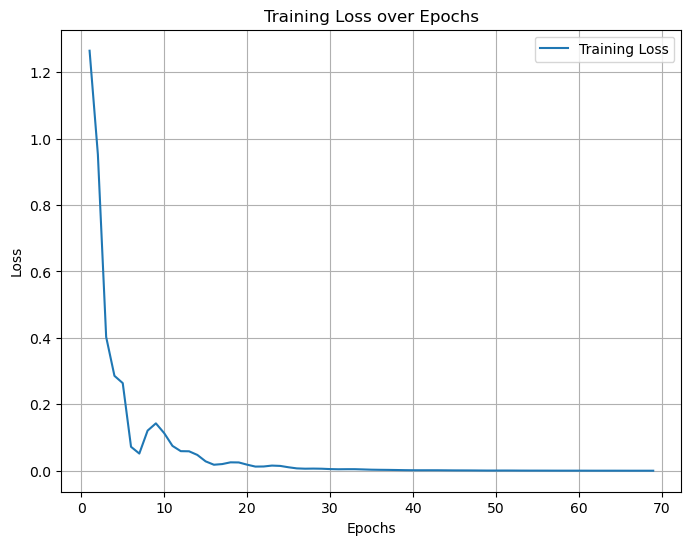

In [30]:
# Train model
q = int(d ** (1/5))  # Setting q as n^(1/5)
h = 1.0  # Example bandwidth

# Define the weight network and the main model
weight_net = WeightNetwork(input_dim=1)  # Neural network to estimate weights
cov_matrix = LR_cov_X(X, q, h, weight_net)  # Long-run covariance matrix with learned weights

x_shape_0 = X.shape[0]
x_shape_1 = X.shape[1]
hidden_dim = 32  # Example hidden layer size
y_shape_0 = Y.shape[0]
y_shape_1 = Y.shape[1]  
cov_dim = d

model = Model1(x_shape_0,x_shape_1, cov_dim, hidden_dim, y_shape_0,y_shape_1)
criterion = nn.MSELoss()
optimizer = optim.Adam(list(model.parameters()) + list(weight_net.parameters()), lr=0.02)

# Training loop
epochs = 500
losses = [] 
for epoch in range(epochs):
    optimizer.zero_grad()
    cov_matrix = LR_cov_X(X, q, h, weight_net)  # Recompute covariance matrix with updated weights
    Y_hat = model(X, cov_matrix)  # Predicted Y(t)
    #print(Y_hat.shape)
    #print(Y.shape)
    loss = criterion(Y_hat, Y)  # Minimize L2 loss between Y_hat and Y
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
     # Check for stopping condition
    if abs(loss.item()) < 1e-4:
        print(f"Stopping early at Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")
        break  # Exit the loop when the loss is sufficiently small


    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(losses) + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid()
plt.show()


Shape of Covariance Matrix (NumPy): torch.Size([6, 6])
torch.Size([50])


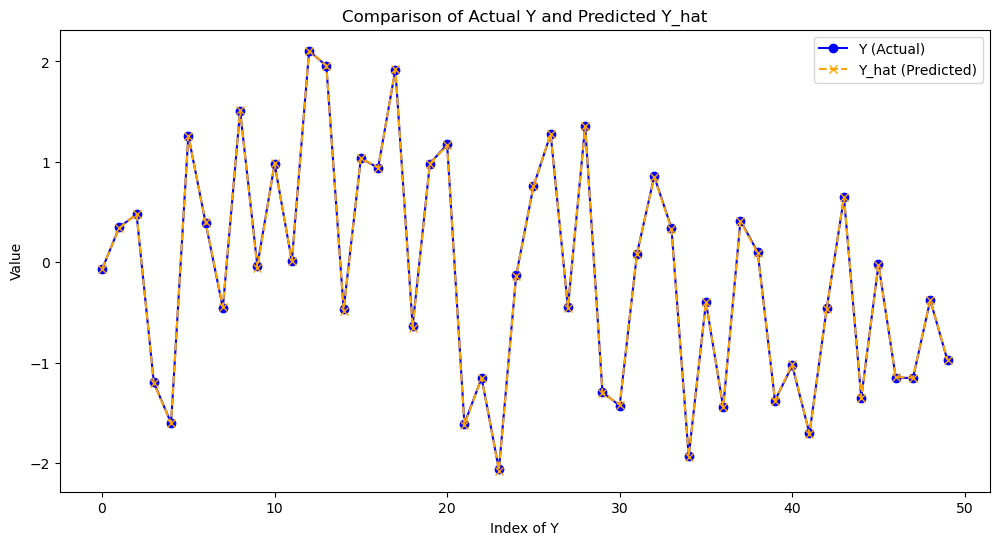

In [31]:
# After training, compute the final predictions for plotting
with torch.no_grad():
    cov_matrix = LR_cov_X(X, q, h, weight_net)
    # Convert to NumPy
    cov_matrix_np = cov_matrix.cpu().numpy()  # Move to CPU and convert to NumPy

    # Print shape of the covariance matrix
    print("\nShape of Covariance Matrix (NumPy):", cov_matrix.size())

    Y_hat = model(X, cov_matrix).view(-1).detach()  # Ensure Y_hat is flattened to match (d,)
    print(Y_hat.size())
    Y_actual = Y.view(-1).detach()  # Flatten Y to (d,)

# Plotting Y and Y_hat
plt.figure(figsize=(12, 6))
# Use PyTorch tensors directly for plotting
plt.plot(range(len(Y_actual)), Y_actual.cpu(), label='Y (Actual)', marker='o', linestyle='-', color='blue')
plt.plot(range(len(Y_hat)), Y_hat.cpu(), label='Y_hat (Predicted)', marker='x', linestyle='--', color='orange')

plt.xlabel("Index of Y")
plt.ylabel("Value")
plt.title("Comparison of Actual Y and Predicted Y_hat")
plt.legend()
plt.show()

In [32]:
cov_matrix

tensor([[ 6.0675e-01, -1.5831e-02,  5.0804e-03, -2.8501e-02, -1.5263e-02,
          1.1312e-02],
        [-1.5831e-02,  3.7527e-01,  1.8622e-02, -2.6514e-02,  2.5036e-02,
          6.5313e-03],
        [ 5.0804e-03,  1.8622e-02,  1.6981e-01,  7.1489e-03, -1.4552e-02,
         -2.2075e-02],
        [-2.8501e-02, -2.6514e-02,  7.1489e-03,  9.7190e-02,  9.6398e-03,
         -2.5131e-04],
        [-1.5263e-02,  2.5036e-02, -1.4552e-02,  9.6398e-03,  5.1258e-02,
          3.0661e-03],
        [ 1.1312e-02,  6.5313e-03, -2.2075e-02, -2.5131e-04,  3.0661e-03,
          8.9099e-03]])

In [33]:
import os

# Ensure the results directory exists
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Convert the tensor to a NumPy array and save it as a CSV file
cov_matrix_np = cov_matrix.cpu().numpy()  # Convert to NumPy (ensure on CPU first)
csv_path = os.path.join(results_dir, "cov_matrix_case2_FMA.csv")

# Save as CSV
np.savetxt(csv_path, cov_matrix_np, delimiter=",", fmt="%.6f")  # Adjust `fmt` for precision

print(f"Covariance matrix saved to {csv_path}")

Covariance matrix saved to results/cov_matrix_case2_FMA.csv


# Compute true covariance matrix